Trial 5 Complete [00h 01m 48s]
val_loss: 0.002523898147046566

Best val_loss So Far: 0.002273679943755269
Total elapsed time: 02h 25m 06s
Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.0419 - mae: 0.1511 - val_loss: 0.0091 - val_mae: 0.0729
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0035 - mae: 0.0460 - val_loss: 0.0153 - val_mae: 0.1094
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0031 - mae: 0.0425 - val_loss: 0.0063 - val_mae: 0.0679
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0027 - mae: 0.0398 - val_loss: 0.0058 - val_mae: 0.0663
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0025 - mae: 0.0388 - val_loss: 0.0042 - val_mae: 0.0518
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0027 - mae: 0.0409 - val_loss: 0.0050 - val_mae: 0.0597
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0020 - mae: 0.0343 - val_loss: 0.0045 - val_mae: 0.0536
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━

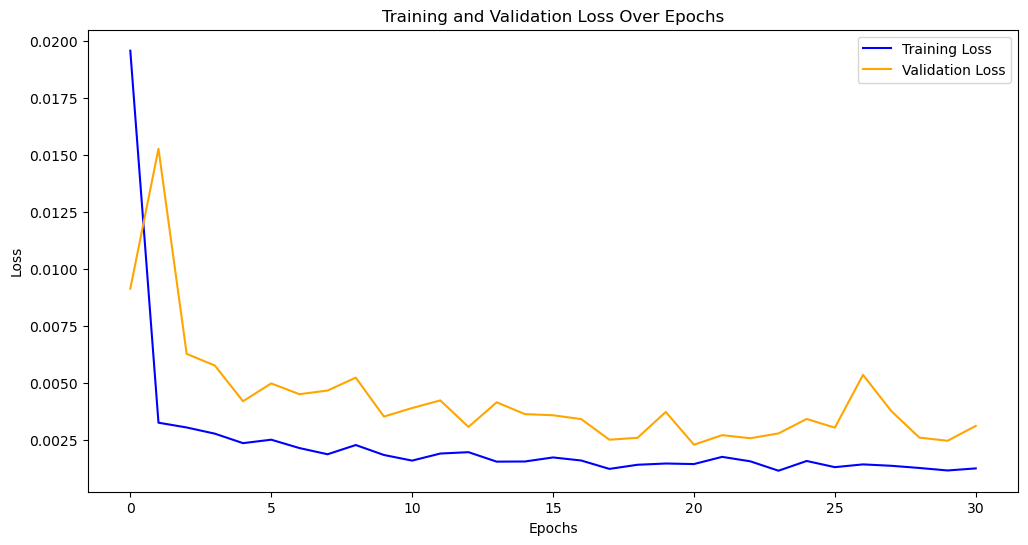

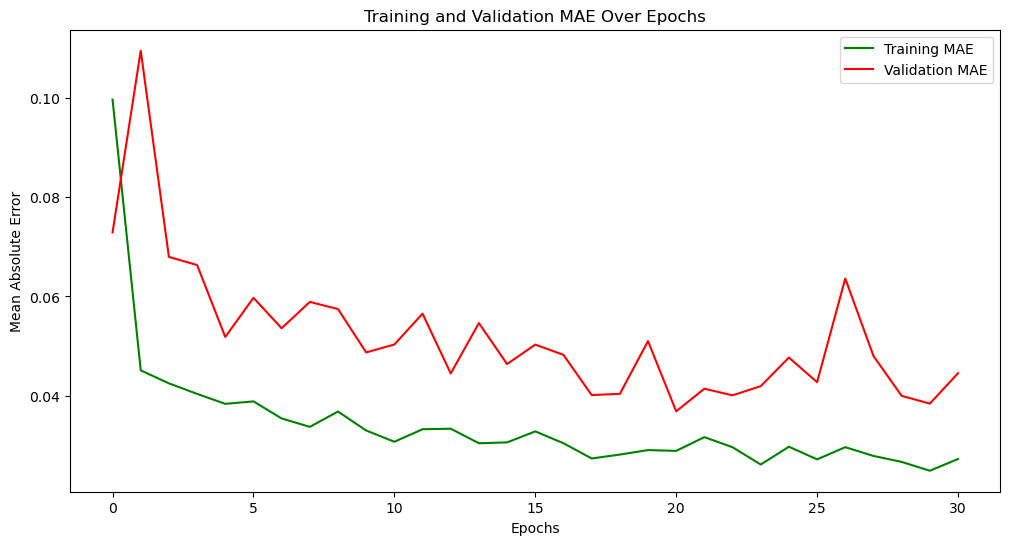

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step


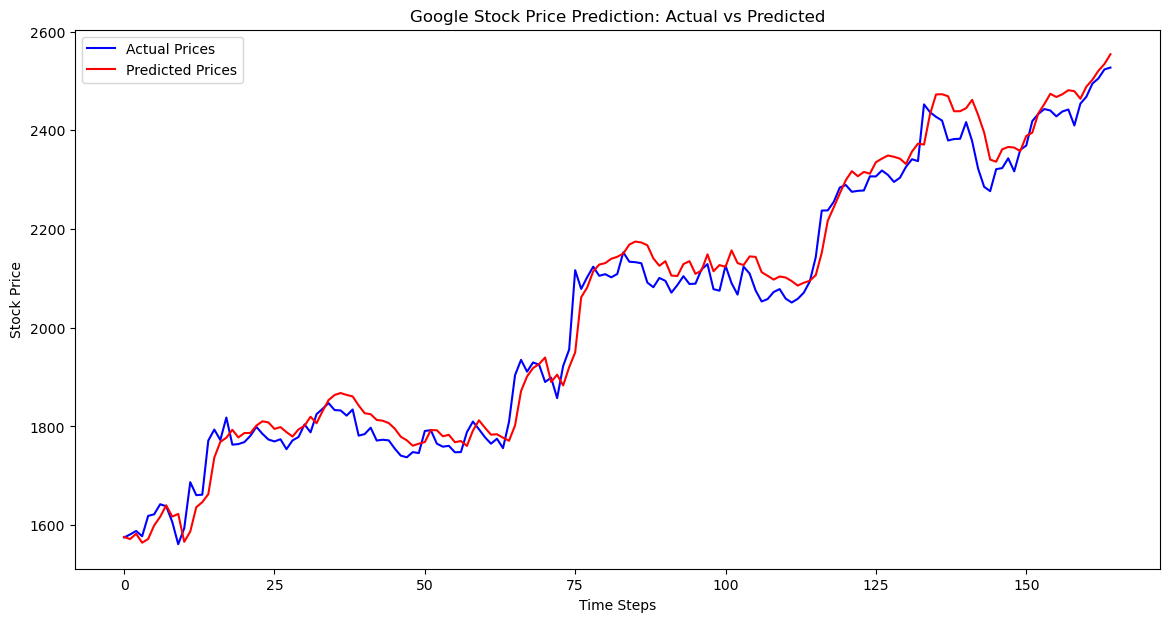

Root Mean Squared Error (RMSE): 41.02133072871067
Mean Absolute Error (MAE): 32.18229237255728


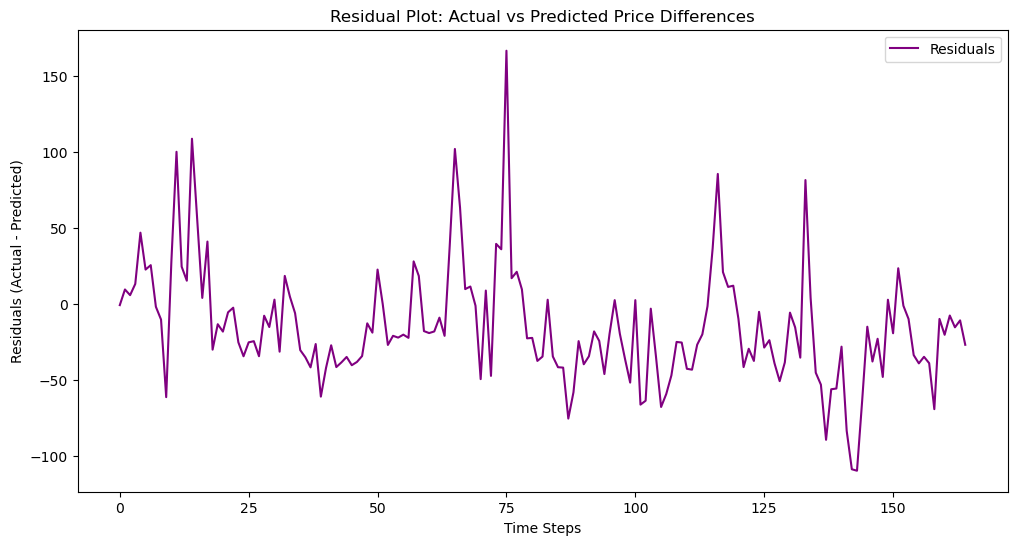

In [31]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional, GRU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('stock_dataset.csv')

# Extracting required columns
df = df[['date', 'open', 'close', 'high', 'low', 'volume']]
df['date'] = pd.to_datetime(df['date'].apply(lambda x: x.split()[0]))
df.set_index('date', drop=True, inplace=True)

# Adding additional features (moving averages, volatility, and more)
df['MA_20'] = df['close'].rolling(window=20).mean()
df['MA_50'] = df['close'].rolling(window=50).mean()
df['Volatility'] = df['close'].rolling(window=20).std()
df['Daily_Return'] = df['close'].pct_change()
df['Price_Range'] = df['high'] - df['low']
df['MA_200'] = df['close'].rolling(window=200).mean()
df.dropna(inplace=True)

# Plotting open and closing price on date index
plt.figure(figsize=(14, 7))
plt.plot(df['open'], label='Open Price', color='green')
plt.plot(df['close'], label='Close Price', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('Open and Close Prices Over Time')
plt.show()

# Splitting the data into training and test set
training_size = round(len(df) * 0.75)
train_data = df[:training_size]
test_data = df[training_size:]

# Normalizing data using MinMaxScaler
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Function to create sequences of data
def create_sequence(dataset, time_step=100):
    sequences = []
    labels = []
    for i in range(len(dataset) - time_step):
        sequences.append(dataset[i:(i + time_step)])
        labels.append(dataset[i + time_step, 2])  # Use 'close' price as label
    return np.array(sequences), np.array(labels)

# Creating sequences for training and testing
time_step = 100
X_train, y_train = create_sequence(train_data_scaled, time_step)
X_test, y_test = create_sequence(test_data_scaled, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], train_data.shape[1]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], train_data.shape[1]))

# Hyperparameter tuning function
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=hp.Int('units_lstm', min_value=50, max_value=200, step=50), return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('dropout_rate_lstm', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(GRU(units=hp.Int('units_gru', min_value=50, max_value=200, step=50), return_sequences=False))
    model.add(Dropout(hp.Float('dropout_rate_gru', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# Hyperparameter tuning with Keras Tuner
import keras_tuner as kt

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='stock_price_prediction'
)

# Run the tuner
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(X_train, y_train, epochs=50, validation_split=0.1, callbacks=[early_stopping], batch_size=16)

# Get the best model and train it
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=16, verbose=1, callbacks=[early_stopping])

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE', color='green')
plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE Over Epochs')
plt.show()

# Evaluate the model on test data
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(np.concatenate((predicted_prices.reshape(-1, 1), np.zeros((len(predicted_prices), train_data.shape[1] - 1))), axis=1))[:, 0]

# Actual prices for comparison
actual_prices = scaler.inverse_transform(test_data_scaled[time_step:])[:, 2]

# Plotting Actual vs Predicted Prices
plt.figure(figsize=(14, 7))
plt.plot(actual_prices, label='Actual Prices', color='blue')
plt.plot(predicted_prices, label='Predicted Prices', color='red')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Google Stock Price Prediction: Actual vs Predicted')
plt.legend()
plt.show()

# Calculating error metrics
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Residual plot to analyze errors
residuals = actual_prices - predicted_prices
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', color='purple')
plt.xlabel('Time Steps')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot: Actual vs Predicted Price Differences')
plt.legend()
plt.show()